In [1]:

%load_ext autoreload
%autoreload 2

Procedure

- Create mesh
    - Generates object with nodes and elements as properties
    - Depends on coordinate system, mesh size, and symmetry conditions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

- Create mesh 
    - Depends on element size and extents
    - Returns coordinate axes (size of each is nx, ny, nz)
- Add structures to mesh
    - Get nodes in struct based on coordinates
    - Change part id of elements in struct
        - All nodes in element should be within struct? 
    -- Generate list of node ids in struct
- Add boundary constraints 
    - Depends on mesh symmetry
    - Change tc and rc of nodes on faces and edges
- Add pml
    - Depends on mesh symmetry and pml thickness
    - Change part id of non-symmetry plane elements
    - Part id + 1 if also in struct
- Finish dyna deck
    - Add material
    - Add load curves
    - Add arf load based on field params (pre-generated)
    - Add database/control parameters
        - Node sets?
- Validation functions
    - Make sure nodes exist on center axis regardless of mesh symmetry so peak arf load is modeled



In [26]:
import fem
import pathlib

from fem.dyna.mesh import Coordinates, DynaMesh
from fem.dyna._structure import Structure
from fem.dyna.material import KelvinMaxwellViscoelastic

project_path = pathlib.Path(fem.__file__).parents[1]
sims_path = project_path.joinpath('sims')
sims_path.mkdir(parents=True, exist_ok=True)

mat1 = KelvinMaxwellViscoelastic(density=1, E=26.11, nu=0.499, eta=2.34)
mat2 = KelvinMaxwellViscoelastic(density=1, E=2*26.11, nu=0.499, eta=2.34)

struct_list = [
    Structure(
        shape = 'rectangle', 
        args = [-1, -0.5, 0, 0.5, -4, -2],
        material = mat2,  
    ), 
    # Structure(
    #     shape = 'sphere', 
    #     args = [0, 0, -2, 1],
    #     material = mat2,  
    # ), 
]

coords = Coordinates(
    nx=51, ny=51, nz=101,
    xmin=-1.0, xmax=0.0,  # ele
    ymin=0.0, ymax=0.5,  # lat
    zmin=-4.0, zmax=-0.15   # ax
)
symmetry = 'q'
mesh = DynaMesh(coords, symmetry, mat1)

mesh.constrain_boundary_nodes()
# mesh.add_pml(pml_thickness=2, exclude_faces=['zmin'])
mesh.add_pml(pml_thickness=2)
# mesh.add_struct_list(struct_list)

mesh.set_control(end_time=4.5e-3)
# mesh.set_control(end_time=2e-3)
mesh.set_database(dt=2e-5)
mesh.set_master(title='testing')

load_curve_id = 1
normalization_isppa = 1000
field_load_file = project_path.joinpath('loads/test_loads.mat')
mesh.add_load_curve(load_curve_id, 'arf', [70e-6, 5e-6])
mesh.add_field_arf_load(field_load_file, normalization_isppa, load_curve_id)

load_folder_name = 'load_0'
material_folder_name = 'material_0'
mesh.write_all_dyna_cards(sims_path, load_folder_name, material_folder_name)


In [10]:
from fem.post.create_disp_dat import create_dat

create_dat(nodout=sim_folder / 'nodout')

INFO:fem.post.create_disp_dat:Reading number of time steps... 
INFO:fem.post.create_disp_dat:there are 50.
INFO:fem.post.create_disp_dat:Time Step: 
INFO:fem.post.create_disp_dat:1, 
INFO:fem.post.create_disp_dat:2, 
INFO:fem.post.create_disp_dat:3, 
INFO:fem.post.create_disp_dat:4, 
INFO:fem.post.create_disp_dat:5, 
INFO:fem.post.create_disp_dat:6, 
INFO:fem.post.create_disp_dat:7, 
INFO:fem.post.create_disp_dat:8, 
INFO:fem.post.create_disp_dat:9, 
INFO:fem.post.create_disp_dat:10, 
INFO:fem.post.create_disp_dat:11, 
INFO:fem.post.create_disp_dat:12, 
INFO:fem.post.create_disp_dat:13, 
INFO:fem.post.create_disp_dat:14, 
INFO:fem.post.create_disp_dat:15, 
INFO:fem.post.create_disp_dat:16, 
INFO:fem.post.create_disp_dat:17, 
INFO:fem.post.create_disp_dat:18, 
INFO:fem.post.create_disp_dat:19, 
INFO:fem.post.create_disp_dat:20, 
INFO:fem.post.create_disp_dat:21, 
INFO:fem.post.create_disp_dat:22, 
INFO:fem.post.create_disp_dat:23, 
INFO:fem.post.create_disp_dat:24, 
INFO:fem.post.create

0

In [12]:
from fem.post.create_res_sim import read_header

dispout = 'disp.dat'
header = read_header(dispout)

print(header)

{'num_nodes': 275, 'num_dims': 4, 'num_timesteps': 50}


In [8]:
from fem.mesh import fem_mesh

node_id_coords = fem_mesh.load_nodeIDs_coords(nodes)
[snic, axes] = fem_mesh.SortNodeIDs(node_id_coords)

print(snic.shape)

(51, 51, 101)


In [15]:
from fem.post.create_res_sim import run as create_res_sim
import pathlib
import fem

load_folder_name = 'load_0'
material_folder_name = 'material_0'

project_path = pathlib.Path(fem.__file__).parents[1]
sims_path = project_path.joinpath('sims')
sim_folder = sims_path / load_folder_name / material_folder_name

dynadeck = sim_folder / 'Master.dyn'
nodes = sims_path / 'nodes.dyn'

create_res_sim(dynadeck, nodedyn=nodes)


INFO:fem.post.create_res_sim:Total Timesteps: 50
INFO:fem.post.create_res_sim:Extracting timestep:
INFO:fem.post.create_res_sim:1


50 0.0 0
[[    51   2652   5253 ... 254949 257550 260151]
 [   102   2703   5304 ... 255000 257601 260202]
 [   153   2754   5355 ... 255051 257652 260253]
 ...
 [  2499   5100   7701 ... 257397 259998 262599]
 [  2550   5151   7752 ... 257448 260049 262650]
 [  2601   5202   7803 ... 257499 260100 262701]]


INFO:fem.post.create_res_sim:2
INFO:fem.post.create_res_sim:3
INFO:fem.post.create_res_sim:4
INFO:fem.post.create_res_sim:5
INFO:fem.post.create_res_sim:6
INFO:fem.post.create_res_sim:7
INFO:fem.post.create_res_sim:8
INFO:fem.post.create_res_sim:9
INFO:fem.post.create_res_sim:10
INFO:fem.post.create_res_sim:11
INFO:fem.post.create_res_sim:12
INFO:fem.post.create_res_sim:13
INFO:fem.post.create_res_sim:14
INFO:fem.post.create_res_sim:15
INFO:fem.post.create_res_sim:16
INFO:fem.post.create_res_sim:17
INFO:fem.post.create_res_sim:18
INFO:fem.post.create_res_sim:19
INFO:fem.post.create_res_sim:20
INFO:fem.post.create_res_sim:21
INFO:fem.post.create_res_sim:22
INFO:fem.post.create_res_sim:23
INFO:fem.post.create_res_sim:24
INFO:fem.post.create_res_sim:25
INFO:fem.post.create_res_sim:26
INFO:fem.post.create_res_sim:27
INFO:fem.post.create_res_sim:28
INFO:fem.post.create_res_sim:29
INFO:fem.post.create_res_sim:30
INFO:fem.post.create_res_sim:31
INFO:fem.post.create_res_sim:32
INFO:fem.post.cr

0

In [27]:
from scipy.io import loadmat

load_folder_name = 'load_0'
material_folder_name = 'material_0'

project_path = pathlib.Path(fem.__file__).parents[1]
sims_path = project_path.joinpath('sims')
sim_folder = sims_path / load_folder_name / material_folder_name

mat = loadmat(sim_folder / 'res_sim.mat')

mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 't', 'ele', 'lat', 'axial', 'arfidata'])

In [28]:
mat['arfidata'].shape

(101, 51, 51, 226)

In [32]:
mat['lat']

array([[0. ],
       [0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5],
       [0.6],
       [0.7],
       [0.8],
       [0.9],
       [1. ],
       [1.1],
       [1.2],
       [1.3],
       [1.4],
       [1.5],
       [1.6],
       [1.7],
       [1.8],
       [1.9],
       [2. ],
       [2.1],
       [2.2],
       [2.3],
       [2.4],
       [2.5],
       [2.6],
       [2.7],
       [2.8],
       [2.9],
       [3. ],
       [3.1],
       [3.2],
       [3.3],
       [3.4],
       [3.5],
       [3.6],
       [3.7],
       [3.8],
       [3.9],
       [4. ],
       [4.1],
       [4.2],
       [4.3],
       [4.4],
       [4.5],
       [4.6],
       [4.7],
       [4.8],
       [4.9],
       [5. ]])

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7efe939c1dd0>


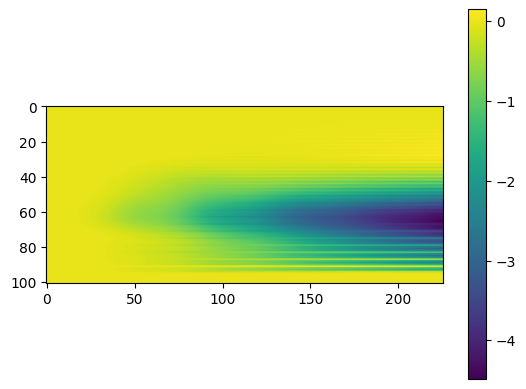

In [30]:
plt.imshow(mat['arfidata'][:,0,50,:])
plt.colorbar()